<a href="https://colab.research.google.com/github/ShivamSinghal1/FacialEmotionRecognition/blob/master/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Importing Dataset

In [6]:
df = pd.read_csv('/content/drive/My Drive/Dataset/fer2013.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### Visualize Dataset

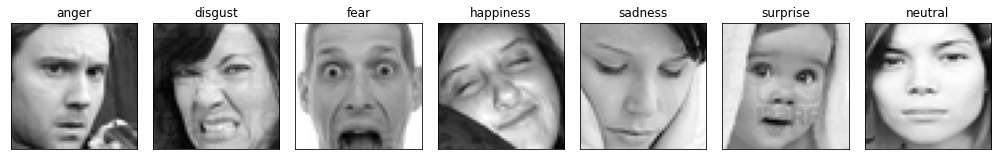

In [10]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

### Input and Output Data

In [11]:
X = df.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(df['emotion'])

In [12]:
X.shape

(35887, 2304)

In [13]:
Y.shape

(35887,)

# Preprocessing
Face Alignment 

In [14]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [15]:
def face_align(gray):
  sz = gray.shape
  # Creating variable eyes
  eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
  if len(eyes) > 1 :
    index=0
    # Creating for loop in order to divide one eye from another
    for (ex , ey,  ew,  eh) in eyes:
      if index == 0:
        eye_1 = (ex, ey, ew, eh)
      elif index == 1:
        eye_2 = (ex, ey, ew, eh)
      index += 1
    if eye_1[0] < eye_2[0]:
      left_eye = eye_1
      right_eye = eye_2
    else:
      left_eye = eye_2
      right_eye = eye_1
        
    # Calculating coordinates of a central points of the rectangles
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    left_eye_x = left_eye_center[0] 
    left_eye_y = left_eye_center[1]
        
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]
    right_eye_y = right_eye_center[1]

    if left_eye_y > right_eye_y:
      A = (right_eye_x, left_eye_y)
      # Integer -1 indicates that the image will rotate in the clockwise direction
      direction = -1 
    else:
      A = (left_eye_x, right_eye_y)
      # Integer 1 indicates that image will rotate in the counter clockwise direction
      direction = 1 
        
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi

    # Width and height of the image
    h, w = gray.shape[:2]
    # Calculating a center point of the image
    # Integer division "//"" ensures that we receive whole numbers
    center = (w // 2, h // 2)
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    # Applying the rotation to our image using the
    # cv2.warpAffine method
    gray = cv2.warpAffine(gray, M, (w, h))

    #Again detecting face
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0 : 
      (x,y,w,h) = faces[0]
      gray = gray[y:y+h, x:x+w]

  gray = cv2.resize(gray,sz) 
  return gray

In [16]:
X_new = []
for j in range(X.shape[0]):
  px = np.array(X[j]).reshape(48,48)
  px = np.array(px, dtype='uint8')
  px = face_align(px)
  X_new.append(np.array(px).reshape(48*48))
X = np.array(X_new)

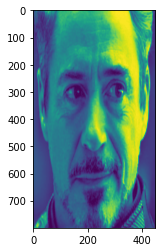

In [17]:
px = cv2.imread('/content/drive/My Drive/Dataset/Robert-Downey-Jr-Avengers-Endgame.jpg')
plt.imshow(px)
gray=cv2.cvtColor(px, cv2.COLOR_BGR2GRAY)
gray = face_align(gray)
plt.imshow(gray)

#### Confusion Matrix

In [18]:
# Plot confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

### Train and Test Split for KNN and SVM


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 2304), (7178, 2304), (28709,), (7178,))

###PCA to retain 95% variation and reduce dataset size

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_valid = scaler.transform(X_valid.astype(np.float32))
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))
X_train_p.shape ,X_test_p.shape 


((28709, 269), (7178, 269))

# SVM

####Using Linear kernel

In [ ]:
model = SVC(kernel = 'linear')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.37405962663694625

####Using rbf kernel

In [ ]:
model = SVC(kernel ='rbf')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.4605739760378936

# KNN

##KNN from scratch

In [20]:
def distance(v1, v2):
	# Eucledian 
	return np.sqrt(((v1-v2)**2).sum())

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.01, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((35528, 2304), (359, 2304), (35528,), (359,))

In [47]:
def knn(X_train, Y_train , test , num ):
	dist = []
	
	for i in range(X_train.shape[0]):
		# Compute the distance from test point
		d = distance(test, X_train[i])
		dist.append([d, Y_train[i]])
	# Sort based on distance 
	dk = sorted(dist, key=lambda x : x[0])
	# Retrieve only the labels
	labels = np.array(dk)[:,-1]
	output = np.zeros(7)
	answer = []
	j = 0
	for k in range(num):
		output[int(labels[k])]+=1
		#u,indices = np.unique(output,return_counts = True)
		#if indices[-1] == 1 or k == num - 1: 
		#	while j <= k : 
		answer.append( np.argmax(output) )
		#		j+=1
	return answer

	# Get frequencies of each label
	#output = np.unique(labels, return_counts=True)
	# Find max frequency and corresponding label
	#index = np.argmax(output[1])
	#return output[0][index]

In [48]:
def wknn(X_train, Y_train , test , num ):
	dist = []
	for i in range(X_train.shape[0]):
		# Compute the distance from test point
		d = distance(test, X_train[i])
		if d == 0:
			d = 0.00000000001 
		dist.append([1/(d*d), Y_train[i]])
	# Sort reverse based on distance and get top k
	dk = sorted(dist, key=lambda x : x[0] , reverse = True)
	output = np.zeros(7)
	answer = []
	for k in range(num):
		output[int(dk[k][1])] += dk[k][0] 
		answer.append( np.argmax(output) )
	return answer

	# Get frequencies of each label
	#output = np.unique(labels, return_counts=True)
	# Find max frequency and corresponding label
	#index = np.argmax(output[1])
	#return output[0][index]

In [49]:
start_time = time.time()

num = 10
cnt = np.zeros(num)
y_pred_manually = []

for i in range(X_valid.shape[0]):
  answer = knn(X_train , y_train , X_valid[i] ,num)
  y_pred_manually.append(answer[0])
  for j in range(num):
    cnt[j] += answer[j] == y_valid[i]

accuracy = cnt/X_valid.shape[0]

print("Maximum Accuracy :",max(accuracy)*100 ,"%")
print("Value of K :",np.argmax(accuracy)+1)
print("Time taken to execute : %s seconds " % (time.time() - start_time))

Maximum Accuracy : 41.5041782729805 %
Value of K : 1
Time taken to execute : 173.55184864997864 seconds 


No handles with labels found to put in legend.


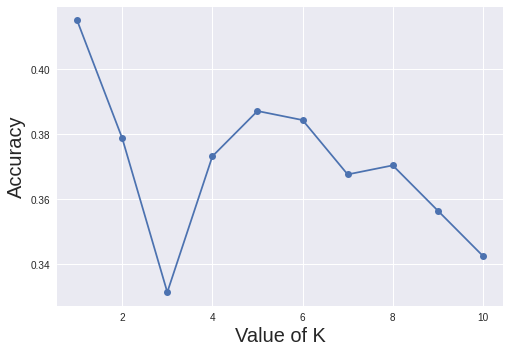

In [50]:
plt.style.use('seaborn')

plt.plot(list(range(1,11)) , accuracy , marker= 'o')
plt.legend(loc = 'upper left',fontsize = 16)
plt.xlabel("Value of K",fontsize = 20)
plt.ylabel("Accuracy",fontsize = 20)
plt.show()

In [51]:
start_time = time.time()

num = 10
cnt = np.zeros(num)
y_pred_manually = []

for i in range(X_valid.shape[0]):
  answer = wknn(X_train , y_train , X_valid[i] ,num)
  y_pred_manually.append(answer[0])
  for j in range(num):
    cnt[j] += answer[j] == y_valid[i]

accuracy = cnt/X_valid.shape[0]

print("Maximum Accuracy :",max(accuracy)*100 ,"%")
print("Value of K :",np.argmax(accuracy)+1)
print("Time taken to execute : %s seconds " % (time.time() - start_time))

Maximum Accuracy : 43.17548746518106 %
Value of K : 8
Time taken to execute : 168.51690769195557 seconds 


No handles with labels found to put in legend.


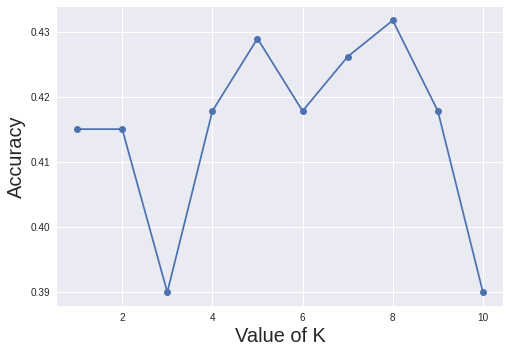

In [52]:
plt.style.use('seaborn')

plt.plot(list(range(1,11)) , accuracy , marker= 'o')
plt.legend(loc = 'upper left',fontsize = 16)
plt.xlabel("Value of K",fontsize = 20)
plt.ylabel("Accuracy",fontsize = 20)
plt.show()

##Applying KNN using SkLearn Library

####Executing sklearn library code to compare on K=1

In [53]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)
classifier.score(X_valid,y_valid)

0.41225626740947074

In [54]:
start_time = time.time()
y_pred = classifier.predict(X_valid)
print("Time Taken : %s seconds " % (time.time() - start_time))

Time Taken : 66.25370788574219 seconds 


In [55]:
cnt = 0
for i in range(X_valid.shape[0]):
   cnt += y_pred[i] == y_valid[i]
print("Accuracy :", cnt/X_valid.shape[0]*100, "%")

Accuracy : 41.22562674094708 %


In [56]:
# Checking manually code prediction with the library code prediction
cnt = 0
for i in range(X_valid.shape[0]):
   cnt += y_pred[i] == y_pred_manually[i]
print("Accuracy :", cnt/X_valid.shape[0]*100, "%")
# All Prediction on these examples are exactly same

Accuracy : 39.83286908077994 %


####KNN using default parameters

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_p ,y_train)
knn.score(X_test_p,y_valid)

0.2679019225410978

####KNN using distance as weight

In [ ]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train_p,y_train)
knn.score(X_test_p,y_valid)

0.3066313736416829

END KNN

# CNN 




In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.1, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 2304), (3589, 2304), (32298,), (3589,))

In [32]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential , load_model
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.initializers import  RandomNormal
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, TensorBoard ,EarlyStopping, ReduceLROnPlateau

In [33]:
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
X_valid = preprocessing.normalize(X_valid)

In [34]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_valid = X_valid.reshape(X_valid.shape[0],48,48,1)

In [35]:
from keras.utils import np_utils
num_classes = 7
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
print("Shape after one-hot encoding: ", y_train.shape)

print(X_train.shape , y_train.shape)
print(X_valid.shape , y_valid.shape)

Shape before one-hot encoding:  (32298,)
Shape after one-hot encoding:  (32298, 7)
(32298, 48, 48, 1) (32298, 7)
(3589, 48, 48, 1) (3589, 7)


In [36]:
def get_cnn_model():
    model = Sequential()

    model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [38]:
model = get_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

# Saving model each time it achieves lower loss on the validation set
filepath='/content/drive/My Drive/Dataset/fer_vgg16_v2.h5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True, mode = 'auto'
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.9,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


history = model.fit(X_train , y_train, batch_size = 32
                   , epochs=35, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpointer,earlystop,reduce_lr]
                             )

pd.DataFrame(history.history).to_csv("history.csv")

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()